In [1]:
import cv2
import numpy as np
from math import log10 , copysign
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os


## Loading Dataset from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/data.zip'

# Destination path to save the zip file in Colab environment
destination_path = '/content/data.zip'

# Copy the zip file to the destination path
!cp "{zip_file_path}" "{destination_path}"

print(f'File has been downloaded to {destination_path}')

File has been downloaded to /content/data.zip


## Unzip The Dataset zipfile

In [4]:
!unzip -q /content/data.zip -d /content/unzipped_data

print('File has been unzipped')


### Here i raname unzipped_data file to Dataset manually.

File has been unzipped


## Get Training Data Ready

In [ ]:
def Get_X_Data(directory,input_shape):
  resized_images = []

  # Target size for resizing
  input_shape = (128, 128) ## CNN
  # input_shape = (75, 75) ## Inception V3

  # Iterate through each file in the directory
  for filename in os.listdir(directory):
      if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Add more extensions if needed
          file_path = os.path.join(directory, filename)

          # Read the image using cv2
          image = cv2.imread(file_path)

          if image is not None:
              # Convert BGR to RGB if necessary
              if image.shape[2] == 3:  # Check if image is already RGB
                  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              elif image.shape[2] == 4:  # Check if image has alpha channel (RGBA)
                  image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)

              # Resize the image to the target size
              resized_image = cv2.resize(image, input_shape)

              # Append the resized image to the list
              resized_images.append(resized_image)
          else:
            print(f"Warning: Unable to read image '{filename}'")
  return resized_image

# # Convert the list of resized images to a numpy array
# x_train = np.stack(resized_images, axis=0)

In [ ]:
def Get_Y_Data(directory):
  labels = []

# Iterate through each file in the directory
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)

        # Read lines from the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Process each line in the file
        for line in lines:
            # Split the line by spaces
            parts = line.split()

            # First part is the label (convert to integer)
            label = int(parts[0])

            # Remaining parts are the features (convert to float)
            feature_values = list(map(float, parts[1:]))

            # Append label and features to lists
            labels.append(label)
  return labels


In [ ]:
resized_images = (Get_X_Data('/content/Dataset/train/images',(128,128)))
x_train = np.stack(resized_images,axis=0)
y_train = Get_Y_Data('/content/Dataset/train/labels')

In [ ]:
x_val = Get_X_Data('/content/Dataset/val/images',(128,128))
y_val = Get_Y_Data('/content/Dataset/val/labels')
x_val.shape,y_val.shape

In [ ]:
x_test = Get_X_Data('/content/Dataset/test/images',(128,128))
y_test = Get_Y_Data('/content/Dataset/test/labels')
x_test.shape,y_test.shape

In [13]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((5421, 128, 128, 3),
 (5421,),
 (1548, 128, 128, 3),
 (1548,),
 (774, 128, 128, 3),
 (774,))

## Frequency Domain of image

In [14]:
from skimage.color import rgb2gray
from numpy.fft import fft2, fftshift

def compute_fourier(image):
    gray_image = rgb2gray(np.asarray(image))
    f = fft2(gray_image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

In [32]:
def Fourier_images(data):
  fourier_feature_list = []

# Iterate through each image in x_train
  for image in data:
      # Compute Fourier Transform and magnitude spectrum
      fft_features = compute_fourier(image)

      # Append the feature vector to the list
      fourier_feature_list.append(fft_features)
  return np.array(fourier_feature_list)

Fourier_X_Train = Fourier_images(x_train)
Fourier_X_Val = Fourier_images(x_val)
Fourier_X_Test = Fourier_images(x_test)

In [33]:
Fourier_X_Train.shape,Fourier_X_Val.shape,Fourier_X_Test.shape

((5421, 128, 128), (1548, 128, 128), (774, 128, 128))

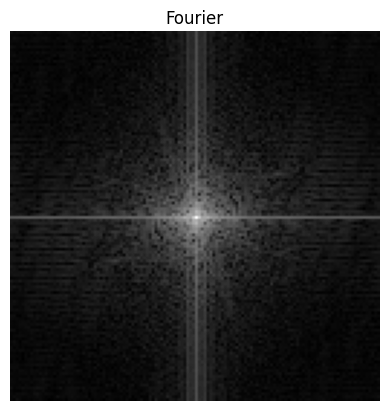

In [ ]:
image = Fourier_X_Train[1]

plt.imshow(image, cmap='gray')
plt.title("Fourier")
plt.axis('off')
plt.show()

## Texture Descriptors : LBP Histogram

In [17]:
from skimage import feature
from skimage.color import rgb2gray

def compute_lbp(image, P=8, R=1):
    gray_image = rgb2gray(np.asarray(image))
    lbp = feature.local_binary_pattern(gray_image, P, R, method="uniform")
    return lbp

In [35]:
def LBP_images(data):
  LBP_feature_list = []

  # Iterate through each image in x_train
  for image in data:
      # Compute LBP texture features
      lbp_features = compute_lbp(image)

      # Append the feature vector to the list
      LBP_feature_list.append(lbp_features)
  return np.array(LBP_feature_list)
# Convert the list of feature vectors to a numpy array
LBP_X_Train = LBP_images(x_train)
LBP_X_Test = LBP_images(x_test)
LBP_X_Val = LBP_images(x_val)

In [36]:
LBP_X_Train.shape,LBP_X_Val.shape,LBP_X_Test.shape

((5421, 128, 128), (1548, 128, 128), (774, 128, 128))

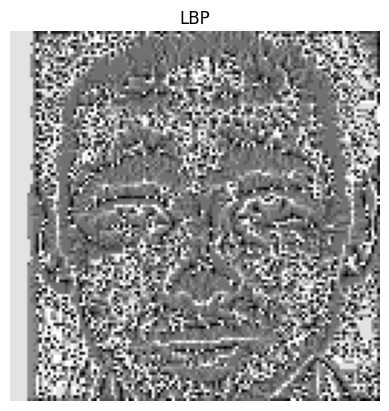

In [ ]:
image = LBP_feature_train[1]

plt.imshow(image, cmap='gray')
plt.title("LBP")
plt.axis('off')
plt.show()

In [21]:
Fourier_X_Train.shape,LBP_X_Train.shape,Fourier_X_Val.shape,LBP_X_Val.shape

((5421, 128, 128), (5421, 128, 128), (1548, 128, 128), (5421, 128, 128))

In [37]:
def ShuffleData(data_fourier,data_lbp):
  all_features = interleaved_array = np.empty((data_fourier.shape[0] + data_lbp.shape[0],) + data_fourier.shape[1:], dtype=data_fourier.dtype)
  interleaved_array[0::2] = data_fourier
  interleaved_array[1::2] = data_lbp
  # all_Val_features.shape
  return all_features


all_Train_features = ShuffleData(Fourier_X_Train,LBP_X_Train)
all_Val_features = ShuffleData(Fourier_X_Val,LBP_X_Val)
all_Test_features = ShuffleData(Fourier_X_Test,LBP_X_Test)
all_Train_features.shape

(10842, 128, 128)

In [24]:
y_train.shape

(5421,)

In [28]:
def DuplicateData(data):
  y_duplicated = np.repeat(data, 2)
  return y_duplicated
y_train_duplicated = DuplicateData(y_train)
y_val_duplicated = DuplicateData(y_val)
y_test_duplicated = DuplicateData(y_test)
y_train_duplicated.shape,y_val_duplicated.shape,y_test_duplicated.shape

((10842,), (3096,), (1548,))

In [38]:
y_train_categorical = to_categorical(y_train_duplicated, num_classes=2)
y_val_categorical = to_categorical(y_val_duplicated, num_classes=2)
y_test_categorical = to_categorical(y_test_duplicated, num_classes=2)

### CNN Model on our data

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

target_shape = (128,128)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_shape[0], target_shape[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(all_train_features, y_train_categorical, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
543/543 [==============================] - 13s 13ms/step - loss: 0.7630 - accuracy: 0.7346 - val_loss: 0.5574 - val_accuracy: 0.7584
Epoch 2/10
543/543 [==============================] - 6s 10ms/step - loss: 0.5771 - accuracy: 0.7387 - val_loss: 0.5535 - val_accuracy: 0.7584
Epoch 3/10
543/543 [==============================] - 6s 11ms/step - loss: 0.5770 - accuracy: 0.7387 - val_loss: 0.5547 - val_accuracy: 0.7584
Epoch 4/10
543/543 [==============================] - 6s 11ms/step - loss: 0.5766 - accuracy: 0.7387 - val_loss: 0.5542 - val_accuracy: 0.7584
Epoch 5/10
543/543 [==============================] - 6s 11ms/step - loss: 0.5754 - accuracy: 0.7387 - val_loss: 0.5533 - val_accuracy: 0.7584
Epoch 6/10
543/543 [==============================] - 6s 11ms/step - loss: 0.5757 - accuracy: 0.7387 - val_loss: 0.5557 - val_accuracy: 0.7584
Epoch 7/10
543/543 [==============================] - 6s 10ms/step - loss: 0.5760 - accuracy: 0.7387 - val_loss: 0.5544 - val_accuracy: 0.758

In [41]:
y_val_categorical = to_categorical(y_val_duplicated, num_classes=2)
test_loss, test_accuracy = model.evaluate(all_Val_features, y_val_categorical)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

97/97 [==============================] - 1s 7ms/step - loss: 0.5817 - accuracy: 0.7319
Test Accuracy: 73.19%


In [42]:
loss, accuracy = model.evaluate(all_Test_features, y_test_categorical, batch_size=32)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

49/49 [==============================] - 0s 8ms/step - loss: 0.5783 - accuracy: 0.7351
Test Accuracy: 73.51%


In [43]:
model.save_weights('CNN_weights.h5')

In [54]:
y_image_test = to_categorical(y_test, num_classes=2)
test_loss, test_accuracy = model.evaluate(gray_x_test, y_image_test)
print(f"Test Accuracy: {test_accuracy}")

49/49 [==============================] - 0s 7ms/step - loss: 0.5817 - accuracy: 0.7319
Test Accuracy: 0.7319121360778809


In [ ]:
import csv

model_name = "simple CNN"

# Prepare the data for the CSV file
data = [["Model Name", "Test Accuracy"], [model_name, test_accuracy]]

# Define the file path for the CSV file
csv_file_path = "model_accuracy.csv"

# Write the data to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

print(f"Accuracy and model name saved to {csv_file_path}")